In [ ]:
pip install bs4 lxml kaggle torchmetrics

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'bilalyousaf0014'
os.environ['KAGGLE_KEY'] = '11031bc21c5e3ec23585dbe17dc4267d'

In [ ]:
!kaggle datasets download -d bilalyousaf0014/ml-engineer-assessment-dataset

In [ ]:
! unzip /content/ml-engineer-assessment-dataset.zip

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np

from torchvision.models import resnet18, ResNet18_Weights

In [ ]:

class Model(nn.Module):

    def __init__(self, num_species=9):
        super(Model, self).__init__()

        # Load the ResNet18 backbone
        self.backbone = nn.Sequential(*list(resnet18().children())[:-2])

        # Add additional layers for object detection, classification, and regression
        backbone_output_size = 512 * 7 * 7  # Output size of the ResNet18 backbone
        self.have_object = nn.Sequential(nn.Linear(backbone_output_size, 1), nn.Sigmoid())
        self.cat_or_dog = nn.Sequential(nn.Linear(backbone_output_size, 2), nn.Softmax(dim=1))
        self.specie = nn.Sequential(nn.Linear(backbone_output_size, num_species), nn.Softmax(dim=1))
        self.bbox = nn.Linear(backbone_output_size, 4)

    def forward(self, input):
        out_backbone = self.backbone(input)

        # Flatten the output of the ResNet18 backbone
        out_backbone = out_backbone.view(out_backbone.size(0), -1)

        # Pass the output of the backbone through the object detection, classification, and regression layers
        have_object = self.have_object(out_backbone)
        cat_or_dog = self.cat_or_dog(out_backbone)
        specie = self.specie(out_backbone)
        bbox = self.bbox(out_backbone)

        return {
            "have_object": have_object,
            "cat_or_dog": cat_or_dog,
            "specie": specie,
            "bbox": bbox
        }


In [ ]:
# CUSTOM DATALOADER IMPLEMENTATION

In [ ]:
train_list = np.load('/content/assessment_dataset/train_list.npy', allow_pickle=True).tolist()
val_list = np.load('/content/assessment_dataset/val_list.npy', allow_pickle=True).tolist()

In [ ]:
from bs4 import BeautifulSoup

def read_xml_file(path):
    with open(path, 'r') as f:
        data = f.read()
    bs_data = BeautifulSoup(data, 'xml')
    its_catdog = False

    if bs_data.find('name') or bs_data.find('name'):

      if bs_data.find("name").text == 'cat' or bs_data.find("name").text =='dog':
              its_catdog = True
      else:
              its_catdog = False

    bbox = [int(bs_data.find("xmin").text), int(bs_data.find("ymin").text), int(bs_data.find("xmax").text),int(bs_data.find("ymax").text) ]
    
    return {
        "cat_or_dog": bs_data.find("name").text,
        "xmin": int(bs_data.find("xmin").text),
        "ymin": int(bs_data.find("ymin").text),
        "xmax": int(bs_data.find("xmax").text),
        "ymax": int(bs_data.find("ymax").text),
        "specie": "_".join(path.split(os.sep)[-1].split("_")[:-1]),
        "have_object" : its_catdog,
        "bbox" : bbox
    }

In [ ]:
from PIL import Image

import torchvision.transforms as transforms

class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, dataset_path, images_list, train=False):
    self.data_source = dataset_path
    self.images_list = images_list
    self.train = train

    image_folder_path = os.path.join(dataset_path, "images")
    label_folder_path = os.path.join(dataset_path, "labels")

    # Define preprocessing transform
    self.preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    self.samples = []
    for path in os.listdir(image_folder_path):
        name = path.split(os.sep)[-1].split(".")[0]
        if name in images_list:
          try:
            xml_path = os.path.join(label_folder_path, name+".xml")
            xml_data = read_xml_file(xml_path)
            
          except FileNotFoundError:
            #print(f"No XML file found for {name}. Skipping...")
            continue
          try:
            image_path = os.path.join(image_folder_path, name+".jpg")
            image = Image.open(image_path).convert("RGB")
            
          except FileNotFoundError:
            #print(f"No JPG file found for {name}. Skipping...")
            continue

          

          if self.preprocess is not None:
            
            image = self.preprocess(image)
          

          labels = {
              "cat_or_dog": xml_data["cat_or_dog"],
              "have_object": xml_data["have_object"],
              "specie": xml_data["specie"],
              "bbox": xml_data["bbox"],

          }
          self.samples.append((image, labels))
          

      
  def __len__(self):
    return len(self.samples)

  def __getitem__(self, index):
    image, labels = self.samples[index]
    #image = transforms.ToPILImage()(image)
    #image = self.preprocess(image)
    return image, labels

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
import torchmetrics

def test(model, val_loader):

  def __tl(x):
    return x.tolist()

  def __tn(x):
    return x.detach().cpu().numpy()

  def __tnl(x):
    return (x.detach().cpu().numpy()).tolist()

  def post_process_object(x):
    return torch.where(x > 0.5, 1.0, 0.0).squeeze(1)

  def post_process_cat_or_dog(x):
    return torch.where(x > 0.5, 1.0, 0.0).squeeze(1)

  def post_process_specie(x):
    return torch.argmax(x, dim=1)

  def post_process_xmin(x):
    return x

  def post_process_ymin(x):
    return x

  def post_process_xmax(x):
    return x

  def post_process_ymax(x):
    return x

  def iou(
      out_xmin,
      out_ymin,
      out_xmax,
      out_ymax,
      lab_xmin,
      lab_ymin,
      lab_xmax,
      lab_ymax
    ):
    min_box_x = torch.max(out_xmin, lab_xmin)
    min_box_y = torch.max(out_ymin, lab_ymin)
    max_box_x = torch.min(out_xmax, lab_xmax)
    max_box_y = torch.min(out_ymax, lab_ymax)
    # print(out_xmin, out_ymin, out_xmax, out_ymax)
    area_over = (
        torch.max(torch.tensor([0]), (max_box_x-min_box_x+torch.tensor(1.0)))
        *torch.max(torch.tensor([0]), max_box_y-min_box_y+torch.tensor(1.0))
      )
    area_box_1 = (out_xmax-out_xmin+1)*(out_ymax-out_ymin+1)
    area_box_2 = (lab_xmax-lab_xmin+1)*(lab_ymax-lab_ymin+1)
    iou = torch.abs(area_over / (area_box_1 + area_box_2 - area_over))
    iou_val = torch.mean(iou)
    return iou_val

  metric_object = torchmetrics.F1Score(task="binary")
  metric_cat_or_dog = torchmetrics.F1Score(task="binary")
  metric_specie = torchmetrics.F1Score(task="multiclass", num_classes=9)

  output_list = {
      "object": [],
      "cat_or_dog": [],
      "specie": [],
      "xmin": [],
      "ymin": [],
      "xmax": [],
      "ymax": [],
  }
  labels_list = {
      "object": [],
      "cat_or_dog": [],
      "specie": [],
      "xmin": [],
      "ymin": [],
      "xmax": [],
      "ymax": [],
  }

  for i, data in enumerate(val_loader):
    inputs, labels = data
    if torch.cuda.is_available():
      inputs = inputs.cuda()
      # for key, value in labels.items():
      #     labels[key] = labels[key].cuda()

    # Make predictions for this batch
    outputs = model(inputs)

    is_object = __tnl(labels["have_object"])
    width = __tn(labels["width"])
    height = __tn(labels["height"])
    output_list["object"].extend(__tnl(post_process_object(outputs["object"])))
    labels_list["object"].extend(__tnl(labels["have_object"]))

    if is_object[0] == 1.0:
      output_list["cat_or_dog"].extend(
        __tnl(post_process_cat_or_dog(outputs["cat_or_dog"]))
      )
      labels_list["cat_or_dog"].extend(
        __tnl(labels["cat_or_dog"])
      )
      output_list["specie"].extend(
        __tnl(post_process_specie(outputs["specie"]))
      )
      labels_list["specie"].extend(__tnl(labels["specie"]))
      output_list["xmin"].extend(
        __tl(__tn(post_process_xmin(outputs["bbox"][:, 0]))*width)
      )
      labels_list["xmin"].extend(__tl(__tn(labels["xmin"])*width))
      output_list["ymin"].extend(
          __tl(__tn(post_process_ymin(outputs["bbox"][:, 1]))*height)
      )
      labels_list["ymin"].extend(
          __tl(__tn(labels["ymin"])*height)
      )
      output_list["xmax"].extend(
          __tl(__tn(post_process_xmax(outputs["bbox"][:, 2]))*width)
      )
      labels_list["xmax"].extend(__tl(__tn(labels["xmax"])*width))
      output_list["ymax"].extend(__tl(__tn(post_process_ymax(outputs["bbox"][:, 3]))*height))
      labels_list["ymax"].extend(__tl(__tn(labels["ymax"])*height))
  
  f1_score_object = metric_object(torch.tensor(output_list["object"]), torch.tensor(labels_list["object"]))
  f1_score_cat_or_dog = metric_cat_or_dog(torch.tensor(output_list["cat_or_dog"]), torch.tensor(labels_list["cat_or_dog"]))
  f1_score_specie = metric_specie(torch.tensor(output_list["specie"]), torch.tensor(labels_list["specie"]))
  mean_iou = iou(
      torch.tensor(output_list["xmin"]),
      torch.tensor(output_list["ymin"]),
      torch.tensor(output_list["xmax"]),
      torch.tensor(output_list["ymax"]),
      torch.tensor(labels_list["xmin"]),
      torch.tensor(labels_list["ymin"]),
      torch.tensor(labels_list["xmax"]),
      torch.tensor(labels_list["ymin"]),
  )
  return f1_score_object, f1_score_cat_or_dog, f1_score_specie, mean_iou
################################## HELPER CODE PROVIDED BY HIRING TEAM ##################################




In [ ]:
def train(epochs, model_weights=None):

  # Initialize Model and Optimizer
  model = Model()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  # Initialize Loss Functions
  have_object_loss = nn.BCEWithLogitsLoss()
  specie_loss = nn.CrossEntropyLoss()
  cat_or_dog_loss = nn.CrossEntropyLoss()
  bbox_loss = nn.SmoothL1Loss() # Not necessary you need to apply function to all coordinates together, You can have separete loss functions for all coordinates too
  # Below or Above
  xmin_loss = nn.SmoothL1Loss()
  ymin_loss = nn.SmoothL1Loss()
  xmax_loss = nn.SmoothL1Loss()
  ymax_loss = nn.SmoothL1Loss()

  if model_weights is not None:
    model.load_state_dict(torch.load(model_weights))

  training_dataset = CustomDataset("/content/assessment_dataset", images_list=train_list)

  if training_dataset is None:
        print("Training dataset is not properly initialized!")
        return

        
  training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True, num_workers=2)

  if torch.cuda.is_available():
    model = model.cuda()

  def train_one_epoch(epoch_index, tb_writer):
      running_loss = 0.
      last_loss = 0.

      # Here, we use enumerate(training_loader) instead of
      # iter(training_loader) so that we can track the batch
      # index and do some intra-epoch reporting
      for i, data in enumerate(training_loader):
          # Every data instance is an input + label pair
          inputs, labels = data

          # Make predictions for this batch
          if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = {k: v.cuda() for k, v in labels.items()}
          
          
          outputs = model(inputs)
          print(outputs)
          print(labels)
          

          # Compute the loss and its gradients
          loss_have_object = have_object_loss(outputs["have_object"], labels["have_object"])
          loss_specie = specie_loss(outputs["specie"], labels["specie"])
          loss_bbox = bbox_loss(outputs["bbox"], labels["bbox"])
          # Above or Below
          loss_xmin = xmin_loss(outputs["bbox"][:, 0], labels["bbox"][:, 0])
          loss_ymin = ymin_loss(outputs["bbox"][:, 1], labels["bbox"][:, 1])
          loss_xmax = xmax_loss(outputs["bbox"][:, 2], labels["bbox"][:, 2])
          loss_ymax = ymax_loss(outputs["bbox"][:, 3], labels["bbox"][:, 3])
          
          loss_cat_or_dog = cat_or_dog_loss(outputs["cat_or_dog"], labels["cat_or_dog"])
          
          

          loss = loss_have_object + loss_specie + loss_cat_or_dog + loss_bbox + loss_xmin + loss_ymin + loss_xmax + loss_ymax  # Consolidate all individual losses

          # Backpropagation and weight updates
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


          

          # Gather data and report
          running_loss += loss.item()
          if i % 10 == 0:
              last_loss = running_loss / 10 # loss per batch
              running_loss = 0.
      return last_loss

  for i in range(epochs):

    epoch_loss = train_one_epoch(i, None)
    print(f' Epoch {i} Loss : {epoch_loss}')

    torch.save("model.pth", model.state_dict())
    metrics = test(model)
    print(metrics)

In [ ]:
train(epochs=10, model_weights=None)

In [ ]:
from PIL import ImageDraw

def visualize(model_weights, image_folder_path, output_folder="output"):

  model = Model()
  model.load_state_dict(torch.load(model_weights))

  try:
    image = Image.open(os.path.join("/content/assessment_dataset/images", image_name+".jpg"))
  except:
    image = Image.open(os.path.join("/content/assessment_dataset/images", image_name+".jpeg"))

  preprocess = None
  output = model()
  return {}

I have used another way to do object detection. Check below:

In [ ]:
!pip install imageai #pillow>=7.0.0 
#train(epochs=10, model_weights=None)

In [ ]:
from imageai.Detection import ObjectDetection

detector = ObjectDetection()

In [ ]:
detector.setModelTypeAsYOLOv3()

In [ ]:
!wget https://github.com/OlafenwaMoses/ImageAI/releases/download/3.0.0-pretrained/yolov3.pt

In [ ]:

detector.setModelTypeAsYOLOv3()
detector.setModelPath("/content/yolov3.pt")
#detector.setJsonPath("hololens-yolo_yolov3_detection_config.json")
detector.loadModel()

In [ ]:
detections = detector.detectObjectsFromImage(input_image="/content/assessment_dataset/images/00001.jpeg", output_image_path="ent/assessment_dataset/images/Abyssinian_109.jpg", minimum_percentage_probability=30)

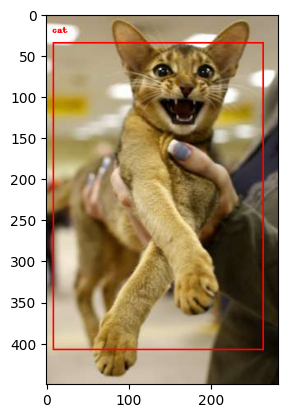

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load image
image_path = '/content/assessment_dataset/images/Abyssinian_109.jpg'
annotations = detector.detectObjectsFromImage(input_image=image_path, minimum_percentage_probability=30)
image = Image.open(image_path)

# Get annotation data
#annotations = [{'name': 'car', 'percentage_probability': 99.98, 'box_points': [20, 51, 252, 145]}]

# Draw bounding box and label on image
draw = ImageDraw.Draw(image)
#font = ImageFont.truetype("arial.ttf", 16)
for annotation in annotations:
    name = annotation['name']
    box = annotation['box_points']
    draw.rectangle(box, outline='red', width=2)
    draw.text((box[0], box[1] - 20), name, fill='red')

# Display image
plt.imshow(image)
plt.show()